In [13]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score


In [19]:
X_train = pd.read_csv("../data/processed/X_train.csv",encoding='latin1',low_memory=False)
X_test  = pd.read_csv("../data/processed/X_test.csv",encoding='latin1',low_memory=False)
y_train = pd.read_csv("../data/processed/y_train.csv",encoding='latin1',low_memory=False)
y_test  = pd.read_csv("../data/processed/y_test.csv",encoding='latin1',low_memory=False)



In [6]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((223769, 6), (55943, 6), (223769, 1), (55943, 1))

In [8]:
model = LinearRegression()
model.fit(X_train, y_train)


,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


Linear Regression as a baseline model because it is simple and interpretable

In [9]:
y_pred = model.predict(X_test)


In [14]:
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae,rmse, r2


(652.8208379924405, 2586.008746494933, 0.04545557312996751)

the model performed poorly =>Airbnb prices are highly "skewed"—most houses are cheap, but a few luxury listings are extremely expensive. These outliers "pull" the regression line away from the majority of the data.

version2: Linear Regression (Log-Price)

In [21]:
import numpy as np
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)


In [22]:
# Initialize a new model instance
log_model = LinearRegression()

# Train using the log-transformed targets
log_model.fit(X_train, y_train_log)

# Make predictions (these will also be in log-scale)
y_pred_log = log_model.predict(X_test)


In [23]:
# Calculate metrics on the log scale
log_mae = mean_absolute_error(y_test_log, y_pred_log)
log_rmse = root_mean_squared_error(y_test_log, y_pred_log)
log_r2 = r2_score(y_test_log, y_pred_log)

print(f"Version 2 (Log) R² Score: {log_r2:.4f}")
print(f"Version 2 (Log) MAE: {log_mae:.4f}")

Version 2 (Log) R² Score: 0.1569
Version 2 (Log) MAE: 0.9469


The $R^2$ score increased to 0.1569, a 4x improvement over the baseline ,Applying a log transformation to the target improved stability and predictive performance.

In [24]:
# Convert log-predictions back to real currency
y_pred_real = np.expm1(y_pred_log) # Assumes your log predictions are in y_pred_log
y_test_real = np.expm1(y_test_log)

final_mae = mean_absolute_error(y_test_real, y_pred_real)
print(f"Final Model Average Error: ${final_mae:.2f}")

Final Model Average Error: $698.81


version3 using random forest

In [29]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train_log.values.ravel())

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",300
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",20
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples 

In [30]:
y_pred_log = rf.predict(X_test)
log_mae = mean_absolute_error(y_test_log, y_pred_log)
log_rmse = root_mean_squared_error(y_test_log, y_pred_log)
log_r2 = r2_score(y_test_log, y_pred_log)

print(f"Version 3 (Log) R² Score: {log_r2:.4f}")
print(f"Version 3 (Log) MAE: {log_mae:.4f}")

Version 3 (Log) R² Score: 0.2175
Version 3 (Log) MAE: 0.9073


The Random Forest captures non-linear relationships between features and price, outperforming the linear baseline.

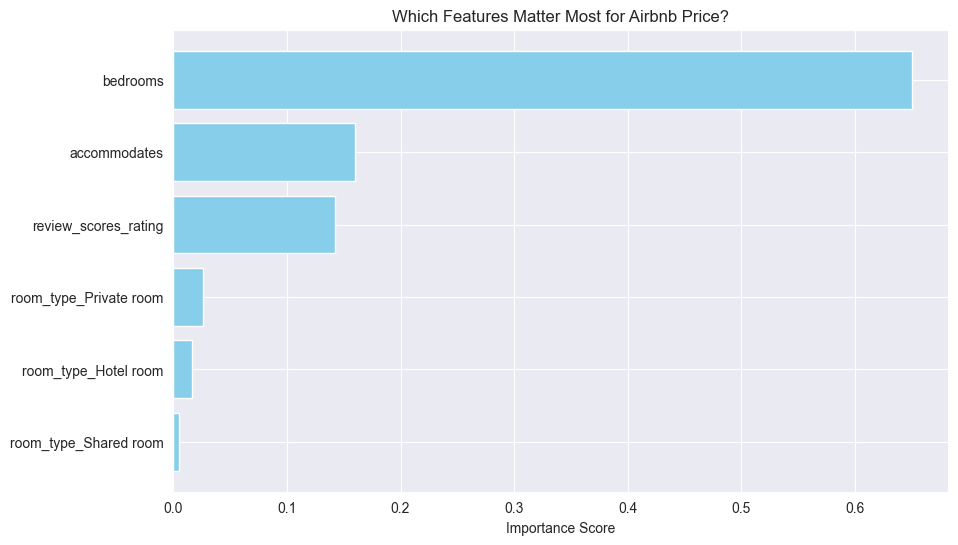

In [31]:
import matplotlib.pyplot as plt
import pandas as pd

# Get importance from the model
importances = rf.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.title('Which Features Matter Most for Airbnb Price?')
plt.gca().invert_yaxis()
plt.show()

Size is the primary driver: The number of bedrooms is the most influential factor, followed by total capacity (accommodates).

Quality adds value: Review scores have a higher impact on price than the specific Room Type, suggesting guests prioritize highly-rated stays over specific room categories.